# RAG retriever training with langchain
<br>
James Chapman<br>
CIS 830 Advanced Topics in AI – Term Project<br>
Kansas State University<br><br>

This notebook creates retrievers used in Retrieval Augmented Generation (RAG).<br>

** Saves all chunks ('data/chunks.jsonl') <br>
** Saves all Contextual chunks ('data/contextual_chunks.jsonl')<br> 

- langchain Documents from 5 sources
    - PubChem - for each drug, get the CID -> https://pubchem.ncbi.nlm.nih.gov/compound/ + CID
    - psychonaut_urls - from get_psychonaut_data.ipynb [Psychonaut's Substance Index](https://psychonautwiki.org/wiki/Psychoactive_substance_index)
    - erowid_urls - get_erowid_data.ipynb [Erowid's Main Chart of substances](https://www.erowid.org/general/big_chart.shtml)
    - CSV - synonym_lists (from 4 sources)
    - CSV - psychonaut_data (Should be better than psychonaut_urls)

- more than 9000 Chunks from documents

- Contextualized Chunks
    - Uses 'chunk_prompt' 
    - Runs o4-mini 
    - Creates contacts for each junk (context within the source document)

- 3 retriever types (for both Contextualized & Non-contextualized)
    - embedding (langchain.vectorstores.FAISS.as_retriever())
    - bm25 (langchain.retrievers.BM25Retriever.from_documents()) 
    - 'combination' = embedding + bm25 + reranker (langchain_cohere.CohereRerank)


TODO: ADD experience reports
TODO: ADD Labeled tweets etc.

# Training contextual retrievers 

largely based off this tutorial: https://github.com/langchain-ai/langchain/blob/master/cookbook/contextual_rag.ipynb
 <br>
Needs semi structured: https://nbviewer.org/github/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb

uses:<br>
langchain_cohere.CohereRerank()<br>
langchain.retrievers.BM25Retriever.from_documents()<br>
langchain.vectorstores.FAISS.as_retriever()

In [1]:
from __future__ import annotations
import logging
logging.disable(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

import os
import pandas as pd
import json
import tiktoken
import matplotlib.pyplot as plt
import time
import uuid
import warnings
import asyncio
from statistics import mean
from collections import Counter, defaultdict, deque
from dataclasses import dataclass, asdict
from tenacity import retry, stop_after_attempt, wait_random_exponential
from typing import Dict, List, Tuple
from pydantic import BaseModel
from time import sleep
from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio as tqdm_a
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path
from contextlib import asynccontextmanager

from langchain_core.documents import BaseDocumentCompressor, Document
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_core.retrievers import BaseRetriever
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document as LangchainDocument
from langchain.retrievers import BM25Retriever
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, SeleniumURLLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_cohere import CohereRerank
from langchain.globals import set_llm_cache
from langchain.cache    import SQLiteCache

set_llm_cache(SQLiteCache(database_path="data/llm_cache.sqlite"))

from dotenv import load_dotenv
load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [ ]:
# API keys
os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["OPENAI_API_KEY"]    = os.getenv('First_Key')
os.environ["ANTHROPIC_API_KEY"] = os.getenv('anthropic-first-key')
os.environ["PPLX_API_KEY"]      = os.getenv('perplexity-api-key')
os.environ["COHERE_API_KEY"]    = os.getenv('cohere-first-key')

# models and embeddings
model_name       = "gpt-4.1-nano" # "gpt-4.1-mini"gpt-4o-mini o4-mini gpt-4.1-nano
model_provider   = "openai"
embeddings_model = "text-embedding-3-large"
llm        = init_chat_model(model_name, model_provider=model_provider)
embeddings = OpenAIEmbeddings(model=embeddings_model)

# constants
MAX_WORKERS      = 28
CONTEXT_WINDOW   = 1047576  # o4-mini tier 2

# drug data 
# substances_of_interest = pd.read_csv('../data/substances_of_interest_list.csv', encoding="utf-8-sig")
drugs_of_interest = pd.read_csv(r"C:\Users\James\OneDrive\Kansas State University\CIS 830\Project_SparKG\data\drugs_with_data7.csv", encoding="utf-8-sig")
drugs_of_interest.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   drug                         77 non-null     object 
 1   CID                          72 non-null     float64
 2   dbid                         29 non-null     object 
 3   DrugBank_ID                  22 non-null     object 
 4   Pharmacology                 38 non-null     object 
 5   Effects                      38 non-null     object 
 6   Toxicity and Harm Potential  38 non-null     object 
 7   Legal Status                 38 non-null     object 
 8   widely_discussed             22 non-null     object 
 9   all_synonyms_list            77 non-null     object 
 10  all_synonyms2                77 non-null     object 
dtypes: float64(1), object(10)
memory usage: 6.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 

In [ ]:
# Prompt to create context for each chunk
chunk_prompt = PromptTemplate(
    input_variables=["WEBPAGE_DESCRIPTION", "WHOLE_DOCUMENT", "CHUNK_CONTENT"],
    template="""You are provided content from a webpage:
        {WEBPAGE_DESCRIPTION}

        Full webpage content:
        {WHOLE_DOCUMENT}

        -----------------------------------------------------
        Here is a smaller chunk we want to situate within the full document:

        {CHUNK_CONTENT}

        Task: Write a short, 2-4 sentence succinct contextualization that situates this chunk within the overall document. 
        Focus on improving search retrieval effectiveness. Describe the chunk's content, its relevance to the document, and any important details.
        **Output only the succinct context. Do not include any extra explanation or formatting.**
        """
)

# 1) LOAD webpages content & 2 CSV's

In [ ]:
# Go to each URL and fetch content
#  - PubChem - for each drug, get the CID -> https://pubchem.ncbi.nlm.nih.gov/compound/ + CID
#  - psychonaut_urls
#  - erowid_urls

################################################################
# helpers
################################################################
def _add_metadata(doc: Document, extra: dict) -> Document:
    content          = doc.page_content or ""
    char_count       = len(content)
    word_count       = len(content.split())
    doc.metadata |= extra | {
        "char_count"   : char_count,
        "word_count"   : word_count,
    }
    return doc

pubchem_base_url = "https://pubchem.ncbi.nlm.nih.gov/compound/"
def fetch_pubchem(row):
    cid, drug = row["CID"], row["drug"]
    if pd.isna(cid): return None
    url = f"{pubchem_base_url}{int(cid)}"
    
    try:
        doc = SeleniumURLLoader([url]).load()[0]
        return _add_metadata(doc, {"source": "pubchem", "url": url,"drug": drug, "cid": int(cid)})
    except Exception:
        return None

def fetch_psychonaut(row):
    drug, url = row["drug"], row["psychonaut_url"]
    if pd.isna(url): return None
    cid_vals   = drugs_of_interest.loc[drugs_of_interest["drug"] == drug, "CID"]
    cid        = int(cid_vals.iloc[0]) if not cid_vals.empty and pd.notna(cid_vals.iloc[0]) else None
    try:
        doc = SeleniumURLLoader([url]).load()[0]
        return _add_metadata(doc, {"source": "psychonaut", "url": url, "drug": drug, "cid": cid})
    except Exception:
        return None

def fetch_erowid(row):
    url = row["url"]
    if pd.isna(url): return None
    drug, substance, category, col = row[["drug", "substance", "category", "erowid_column"]]
    cid_vals   = drugs_of_interest.loc[drugs_of_interest["drug"] == drug, "CID"]
    cid        = int(cid_vals.iloc[0]) if not cid_vals.empty and pd.notna(cid_vals.iloc[0]) else None
    try:
        doc = SeleniumURLLoader([url]).load()[0]
        return _add_metadata(doc, {"source": "erowid", "url": url, "drug": drug, "cid": cid, 
                                   "substance": substance, "category": category, "erowid_column": col}) # erowid specific
    except Exception:
        return None

################################################################
# Go to each website and fetch content, add pubchem, metadata, and save
################################################################
documents: List[Document] = []
# futures   = []
# with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
#     # each website 
#     futures += [ex.submit(fetch_pubchem,    r) for _, r in drugs_of_interest.iterrows()]
#     futures += [ex.submit(fetch_psychonaut, r) for _, r in psychonaut_urls.iterrows()]
#     futures += [ex.submit(fetch_erowid,     r) for _, r in erowid_urls.iterrows()]
#     # distribute futures across workers
#     for done in tqdm(as_completed(futures), total=len(futures)):
#         doc = done.result()
#         if doc: # check for success
#             documents.append(doc)



Loaded 229 documents


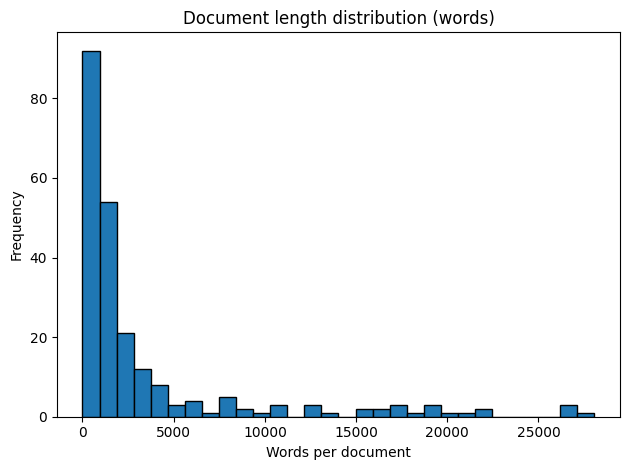

In [ ]:
# HISTOGRAM
word_counts = [
    doc.metadata["word_count"]
    for doc in documents
    if "word_count" in doc.metadata
]
plt.hist(word_counts, bins=30, edgecolor="k")
plt.title("Document length distribution (words)")
plt.xlabel("Words per document")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# add CSV files as langchain documents

#################################################################
# CSV # 1 psychonaut wiki 
################################################################
psychonaut_data_path = r"C:\Users\James\OneDrive\Kansas State University\CIS 830\Project_SparKG\data\psychonaut_data.csv"
loader = CSVLoader(file_path=psychonaut_data_path, encoding="utf-8-sig")
csv_docs = loader.load()                # one Document per row
for d in csv_docs:
    # tag the source so you know which file it came from
    d.metadata["source"] = "psychonaut_CSV"
documents.extend(csv_docs)
print(f"✅ Loaded {len(csv_docs):,} docs from psychonaut_CSV")

################################################################
# CSV # 2 synonym lists (from 4 sources)
################################################################
synonym_lists_path = r"C:\Users\James\OneDrive\Kansas State University\CIS 830\Project_SparKG\data\synonym_lists.csv"
loader = CSVLoader(file_path=synonym_lists_path, encoding="utf-8-sig")
csv_docs = loader.load() # one Document per row
for d in csv_docs:
    # tag the source so you know which file it came from
    d.metadata["source"] = "synonym_lists_CSV"
documents.extend(csv_docs)
print(f"✅ Loaded {len(csv_docs):,} docs from synonym_lists_CSV")

# # SAVE
# with Path("data/documents2.jsonl").open("w", encoding="utf-8-sig") as f:
#     for doc in documents:
#         json.dump({"metadata": doc.metadata, "content": doc.page_content},
#                   f, ensure_ascii=False)
#         f.write("\n")

# Load the file into a DataFrame
documents: list[Document] = []
with Path("data/documents2.jsonl").open("r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():          # skip blank lines
            continue
        obj = json.loads(line)
        documents.append(
            Document(
                page_content=obj.get("content", ""),
                metadata=obj.get("metadata", {}),
            )
        )
print(f"Loaded {len(documents):,} documents")

✅ Loaded 77 docs from psychonaut_CSV
✅ Loaded 133 docs from synonym_lists_CSV


# 2) Split into chunks

In [ ]:
# Simple text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=1_000, chunk_overlap=200)
chunks: List[Document] = []
for d_idx, document in enumerate(documents):
    doc_id = document.metadata.setdefault("doc_id", f"doc_{d_idx}")
    doc_chunks  = splitter.split_documents([document])
    document.metadata["num_chunks"] = len(doc_chunks)
    for c_idx, chunk in enumerate(doc_chunks):
        chunk.metadata.update({
            "doc_id": doc_id,
            "chunk_id": f"{d_idx}::chunk_{c_idx}",
            "document_index": d_idx,
        })
        chunks.append(chunk)

# Save
# with Path("data/chunks2.jsonl").open("w", encoding="utf-8-sig") as f:
#     for chunk in chunks:
#         json.dump({"metadata": chunk.metadata, "content": chunk.page_content},
#                   f, ensure_ascii=False)
#         f.write("\n")

# Print summary
print(f"Total chunks: {len(chunks):,}")
chunk_meta_keys = set()
for ch in chunks:
    chunk_meta_keys.update(ch.metadata.keys())
print(f"\nPossible chunk-metadata keys ({len(chunk_meta_keys)} total):")
for key in sorted(chunk_meta_keys):
    print(f"  • {key}")

Total chunks: 9,695

Possible chunk-metadata keys (16 total):
  • category
  • char_count
  • chunk_id
  • cid
  • description
  • doc_id
  • document_index
  • drug
  • erowid_column
  • language
  • row
  • source
  • substance
  • title
  • url
  • word_count


# 3) Generate Context for each Website for Contextual Retrievers

In [7]:
# for each webpage, get a 2 sentence description of the page and its sections
webpage_description_prompt_text = PromptTemplate(input_variables=[], 
                                                 template = """ You are an expert web analyst.  
Your task:  
1. Visit the webpages listed below (use them only as structural examples; you don’t need to cover every compound/substance).  
2. For each group of webpages, study their shared layout and content sections.  
3. Produce a **3-4 sentence description** that captures the common structure/content.  
4. Return your results **only** as a JSON object with these keys:  

   - "pubchem"  
   - "psychonaut"  
   - "erowid_main_page"  
   - "erowid_basics"  
   - "erowid_law"  
   - "erowid_dose"  
   - "erowid_faq"  
   - "erowid_effects"  
   - "erowid_chemistry"  
   - "erowid_testing"  
   - "erowid_health"  
   - "erowid_history"  
   - "erowid_journals"  
   - "erowid_writings"  
   - "erowid_media"  

5. Do **not** include any additional commentary—return only the JSON.

**Example pages to review**

**PubChem compound pages**  
- https://pubchem.ncbi.nlm.nih.gov/compound/3034396  
- https://pubchem.ncbi.nlm.nih.gov/compound/7-Hydroxycannabidiol  
- https://pubchem.ncbi.nlm.nih.gov/compound/5284603  

**PsychonautWiki drug pages**  
- https://m.psychonautwiki.org/wiki/Oxycodone  
- https://m.psychonautwiki.org/wiki/Hydromorphone  
- https://m.psychonautwiki.org/wiki/Amphetamine  

**Erowid**  
Main “Big Chart” index: https://www.erowid.org/general/big_chart.shtml  

For each Erowid category below, sample at least two substance pages (e.g., ketamine, LSD, MDMA, etc.)—ignore “Books” and “Images” sections:  
- MainPage (`.../SUBSTANCE/SUBSTANCE.shtml`)  
- Basics (`..._basics.shtml`)  
- Law (`..._law.shtml`)  
- Dose (`..._dose.shtml`)  
- FAQ (`..._faq.shtml`)  
- Effects (`..._effects.shtml`)  
- Chemistry (`..._chemistry.shtml`)  
- Testing (`..._testing.shtml`)  
- Health (`..._health.shtml`)  
- History / Timeline (`..._timeline.php`)  
- Journals (`..._journal.shtml`)  
- Writings (`..._writings.shtml`)  
- Media (`..._media.shtml`)  

For each Erowid category, also include a one sentence description of the Erowid websites.
Then, Follow the five rules above and output the final JSON only. 
Return ONLY the JSON object, with no markdown, back-ticks or commentary.

""")

# Run the prompt
webpage_description_response = llm.invoke(webpage_description_prompt_text.format()).content
webpage_description_json = json.loads(webpage_description_response)

# Save 
with open("data/webpage_description2.json", "w") as f:
    json.dump(webpage_description_json, f, indent=4)

for webpage in webpage_description_json:
    print('-------------', webpage)
    print(webpage_description_json[webpage])

------------- pubchem
PubChem compound pages share a structured layout centered around chemical information, including sections like molecular structure, properties, biological activities, safety, and references. Content is organized systematically to provide detailed chemical and pharmacological data, often with tabs or sections for easy navigation. Visuals such as chemical structures and links to related compounds are prominent features. The focus is on comprehensive chemical data and scientific resources for researchers and professionals.
------------- psychonaut
PsychonautWiki drug pages typically feature a simplified, user-friendly design with sections covering drug effects, risks, administration methods, and harm reduction tips. Content is organized into clear headings that guide users through effects, dosage, and safety information. Visual icons and tables are used to enhance readability and quick reference. The site emphasizes harm reduction, personal experiences, and factual d

# 4) Contextual Chunks
- For every chunk (from every document)
    - Use LLM to create context
    - (context of chunk within entire document)
    - This will be added to RAG prompt, after retrieval

In [8]:
class RateLimiter:
    def __init__(self, rpm: int, tpm: int, window: int = 60):
        self.rpm   = rpm
        self.tpm   = tpm
        self.win   = window
        self.req_ts   = deque() # timestamps of each request
        self.tok_usage = deque() # (timestamp, tokens_used)
        self.tok_sum  = 0

    def _purge_expired(self) -> None:
        """Drop entries that slid out of the time window."""
        cutoff = time.time() - self.win
        while self.req_ts   and self.req_ts[0]   < cutoff:
            self.req_ts.popleft()
        while self.tok_usage and self.tok_usage[0][0] < cutoff:
            _, tok = self.tok_usage.popleft()
            self.tok_sum -= tok

    def wait(self, tokens_expected: int) -> None:
        """
        Call **before** you hit the endpoint.
        Blocks until the new request can be made without breaking the budget.
        """
        while True:
            self._purge_expired()
            # Will this request break either budget?
            if (len(self.req_ts)   < self.rpm) and \
               (self.tok_sum+tokens_expected < self.tpm):
                break                         # safe to proceed
            # otherwise sleep until the earliest item ages-out
            earliest_req_expiry = self.win - (time.time() - self.req_ts[0]) \
                                   if self.req_ts else self.win
            earliest_tok_expiry = self.win - (time.time() - self.tok_usage[0][0]) \
                                   if self.tok_usage else self.win
            time.sleep(max(0.01, min(earliest_req_expiry, earliest_tok_expiry)))
        # reserve the slot
        now = time.time()
        self.req_ts.append(now)
        self.tok_usage.append((now, tokens_expected))
        self.tok_sum += tokens_expected

    def add_completion_tokens(self, n: int) -> None:
        """
        Call **after** receiving the model’s reply to account for completions.
        """
        now = time.time()
        self.tok_usage.append((now, n))
        self.tok_sum += n


In [10]:
###############################################################################
# tiktoken Encoding is used to estimate tokens for rate limiter
###############################################################################
try:
    enc = tiktoken.encoding_for_model(model_name)
except KeyError:
    enc =  tiktoken.get_encoding("cl100k_base")
_toklen = lambda txt: len(enc.encode(txt))

###############################################################################
# initiate the rate limiter
###############################################################################
# limiter = None
limiter = RateLimiter(rpm=5000, tpm=4000000)  # rpm=100, tpm=200_000) rpm=500, tpm=30_000)

###############################################################################
# Check for token length and retry if it fails
# I was having issues with timing out, so I added the retry 
###############################################################################
def _invoke_llm(llm, prompt):
    prompt_toks = _toklen(prompt)
    if prompt_toks >= CONTEXT_WINDOW:
        raise ValueError("Prompt exceeds context window")
    # decides if to wait
    if limiter:
        limiter.wait(prompt_toks)

    # A decorator for retry after error
    @retry(stop=stop_after_attempt(3), wait=wait_random_exponential(1, 10))
    def _call():
        start = time.perf_counter()
        resp  = llm.invoke(prompt)
        latency_s   = time.perf_counter() - start
        if hasattr(resp, "content"):
            resp_text = resp.content.strip()
        else:
            resp_text = resp.strip()
        if not resp_text:
            raise ValueError("Empty LLM response – retrying")
        completion_toks = _toklen(resp_text)
        if limiter:
            limiter.add_completion_tokens(completion_toks)
        return resp_text, latency_s, prompt_toks, completion_toks
    return _call()

###############################################################################
# Make HEADER from metadata, embedded in each chunk (for context)
###############################################################################
def _make_header(metadata: dict) -> str:
    # metadata dictionary keys:
    # • category       • char_count    • chunk_id  • cid   • doc_id
    # • document_index • erowid_column • language  • drug  • num_chunks  • url  
    # • response_type  • description   • substance • title • word_count
    lines = [
        f"Drug: {metadata.get('drug', 'Unknown')} | cid: {metadata.get('cid', 'N/A')}",
        f"Source: {metadata.get('source', 'N/A')} | Source description: {metadata.get('description', '?')}"
    ]
    if metadata.get("substance"): lines.append(f"Erowid name: {metadata['substance']}")
    if metadata.get("category"):  lines.append(f"Category: {metadata['category']}")
    if metadata.get("erowid_column"):    lines.append(f"Field: {metadata['erowid_column']}")
    return "\n".join(lines)

###############################################################################
# THE prompt
###############################################################################
chunk_prompt = PromptTemplate(
    input_variables=["WEBPAGE_DESCRIPTION", "WHOLE_DOCUMENT", "CHUNK_CONTENT"],
    template="""You are provided content from a webpage:
        {WEBPAGE_DESCRIPTION}

        Full webpage content:
        {WHOLE_DOCUMENT}

        -----------------------------------------------------
        Here is a smaller chunk we want to situate within the full document:

        {CHUNK_CONTENT}

        Task: Write a short, 2-4 sentence succinct contextualization that situates this chunk within the overall document. 
        Focus on improving search retrieval effectiveness. Describe the chunk's content, its relevance to the document, and any important details.
        **Output only the succinct context. Do not include any extra explanation or formatting.**
        """
)

###############################################################################
###############################################################################
# Contextualize chunks - add context to each chunk 
###############################################################################
###############################################################################

splitter = RecursiveCharacterTextSplitter(chunk_size=1_000, chunk_overlap=200)
total_toks   = 0
start_time_s = time.time()
prev_time_s = time.time()

successful = {int(p.stem) for p in Path("data/contextual_chunks2").glob("*.jsonl") if p.stem.isdigit()}
for d_idx, document in enumerate(documents):
    if d_idx in successful:
        continue
    try:
        # Split current document
        doc_chunks = splitter.split_documents([document])
        document.metadata["num_chunks"] = len(doc_chunks)
        doc_id = document.metadata.setdefault("doc_id", f"doc_{d_idx}")
        # for each chunk, create contextual_chunk
        doc_contextual_chunks = []
        with tqdm(doc_chunks, desc="Contextualizing") as pbar:
            for c_idx, chunk in enumerate(pbar): # should be same as old chunks
                chunk.metadata.update({
                    "doc_id": doc_id,
                    "chunk_id": f"{d_idx}::chunk_{c_idx}",
                    "document_index": d_idx,
                })
                # gather webpage description
                source = chunk.metadata["source"]
                if source == "erowid":
                    category = chunk.metadata.get("category", "general")
                    webpage_description = webpage_description_json.get(f"erowid_{category}", "")
                else:
                    webpage_description = webpage_description_json.get(source, "")
                # create prompt and run it
                prompt_text = chunk_prompt.format(
                    WEBPAGE_DESCRIPTION=webpage_description,
                    WHOLE_DOCUMENT=document.page_content,
                    CHUNK_CONTENT=chunk.page_content
                )
                resp_text, latency_s, prompt_toks, completion_toks = _invoke_llm(llm, prompt_text)
                # handle metadata
                contextual_chunk_metadata=chunk.metadata.copy()
                contextual_chunk_metadata.update({
                    "latency_s": latency_s,
                    "prompt_toks": prompt_toks,
                    "completion_toks": completion_toks,
                })
                header = _make_header(contextual_chunk_metadata)
                # TODO: rewrite this content
                page_content = f"""{header}\n
                    Text: 
                    {chunk.page_content}\n\n
                    Context: 
                    {resp_text}
                """
                new_chunk = Document(page_content=page_content, metadata=contextual_chunk_metadata)
                doc_contextual_chunks.append(new_chunk)
                ###### Progress bar ###############################################
                total_toks += prompt_toks + completion_toks
                elapsed_s   = time.time() - start_time_s
                tpm         = (total_toks / elapsed_s) * 60 if elapsed_s else 0
                now_s       = time.time()
                iter_s      = now_s - prev_time_s
                iter_toks   = prompt_toks + completion_toks
                iter_tpm    = (iter_toks / iter_s) * 60 if iter_s else 0
                prev_time_s = now_s
                pbar.set_postfix(
                    iTPM=f"{iter_tpm:,.0f}",
                    avgTPM=f"{tpm:,.0f}",
                    Prompt=prompt_toks,
                    Completion=completion_toks,
                    Latency=f"{latency_s:.1f}s"
                )
                ####################################################################
        # Current document/webpage Complete
        with Path(f"data/contextual_chunks2/{d_idx}.jsonl").open("w", encoding="utf-8-sig") as f:
            for chunk in doc_contextual_chunks:
                json.dump({"metadata": chunk.metadata, "content": chunk.page_content}, f, ensure_ascii=False)
                f.write("\n")
    except KeyboardInterrupt: break
    except Exception as e:
        print(f"Error processing document {d_idx}: {e}")
        pass



Contextualizing: 100%|██████████| 6/6 [00:05<00:00,  1.19it/s, Completion=69, Latency=0.7s, Prompt=1544, avgTPM=1,347,602, iTPM=142,238]
Contextualizing: 0it [00:00, ?it/s]
Contextualizing: 100%|██████████| 103/103 [01:48<00:00,  1.06s/it, Completion=80, Latency=0.9s, Prompt=16271, avgTPM=1,322,484, iTPM=1,037,439]
Contextualizing: 0it [00:00, ?it/s]
Contextualizing: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s, Completion=65, Latency=0.7s, Prompt=369, avgTPM=1,164,550, iTPM=34,514]


In [ ]:
contextual_chunks = []
DATA_CHUNKS_DIR = Path("data/contextual_chunks2")

for fpath in sorted(
        DATA_CHUNKS_DIR.glob("*.jsonl"),
        key=lambda p: int(p.stem) if p.stem.isdigit() else p.stem
):
    with fpath.open(encoding="utf-8-sig") as f:
        for line in f:
            record = json.loads(line)
            contextual_chunks.append(
                Document(
                    page_content=record["content"],
                    metadata=record["metadata"],
                )
            )

print(f"Loaded {len(contextual_chunks):,} contextual chunks "
      f"from {len(list(DATA_CHUNKS_DIR.glob('*.jsonl')))} files.")

########################################################################
# # Save contextualized chunks to JSONL
########################################################################
# with Path("data/contextual_chunks2.jsonl").open("w", encoding="utf-8-sig") as f:
#     for chunk in contextual_chunks:
#         json.dump({"metadata": chunk.metadata, "content": chunk.page_content},
#                   f, ensure_ascii=False)
#         f.write("\n")
########################################################################

Loaded 9,695 contextual chunks from 439 files.


# 5) Create Retrievers
- Contextual & Non-Contextual 

In [12]:
# We now have 2 kinds of chunks: 'vanilla' and 'contextualized'
# Create 3 types of retrievers: (for each type of chunking)
#       'embedding', 
#       'bm25',  
#       'combination' = embedding + bm25 + reranker

######  reranker  ##############################################################
reranker = CohereRerank(top_n=3, model="rerank-english-v3.0") #"rerank-english-v2.0")
################################################################################
#
def create_embedding_retriever(documents_):
    vector_store = FAISS.from_documents(documents_, embedding=embeddings)
    return vector_store.as_retriever(search_kwargs={"k": 4})

def batch_embed_texts(texts, embedding_model, chunk_size=100):
    all_embeddings = []
    for i in range(0, len(texts), chunk_size):
        batch = texts[i:i + chunk_size]
        all_embeddings.extend(embedding_model.embed_documents(batch))
    return all_embeddings

def batch_create_embedding_retriever(documents_):
    texts = [doc.page_content for doc in documents_]
    metadatas = [doc.metadata for doc in documents_]

    # Safe batching to avoid max token limits
    embeddings_list = batch_embed_texts(texts, embeddings, chunk_size=100)

    text_embedding_pairs = zip(texts, embeddings_list)

    return FAISS.from_embeddings(text_embeddings=text_embedding_pairs, embedding=embeddings, metadatas=metadatas).as_retriever(search_kwargs={"k": 4})


def create_bm25_retriever(documents_):
    retriever = BM25Retriever.from_documents(documents_, language="english")
    return retriever

# Function to create a combined retriever: embedding + BM25 + reranker
class EmbeddingBM25RerankerRetriever:
    def __init__(
        self,
        vector_retriever: BaseRetriever,
        bm25_retriever: BaseRetriever,
        reranker: BaseDocumentCompressor,
    ):
        self.vector_retriever = vector_retriever
        self.bm25_retriever = bm25_retriever
        self.reranker = reranker

    def invoke(self, query: str):
        vector_docs = self.vector_retriever.invoke(query)
        bm25_docs = self.bm25_retriever.invoke(query)

        combined_docs = vector_docs + [
            doc for doc in bm25_docs if doc not in vector_docs
        ]

        reranked_docs = self.reranker.compress_documents(combined_docs, query)
        return reranked_docs
    
##################################################################################
# vanilla chunks
##################################################################################

embedding_retriever = create_embedding_retriever(chunks)

bm25_retriever = create_bm25_retriever(chunks)

embedding_bm25_retriever_rerank = EmbeddingBM25RerankerRetriever(
    vector_retriever=embedding_retriever,
    bm25_retriever=bm25_retriever,
    reranker=reranker,
)

##################################################################################
# contextualized chunks
##################################################################################

contextual_embedding_retriever = batch_create_embedding_retriever(contextual_chunks)

contextual_bm25_retriever = create_bm25_retriever(contextual_chunks)

contextual_embedding_bm25_retriever_rerank = EmbeddingBM25RerankerRetriever(
    vector_retriever=contextual_embedding_retriever,
    bm25_retriever=contextual_bm25_retriever,
    reranker=reranker,
)

# Test Retrievers on fake data
- See what they retrieve

In [13]:

llm_prompt_without_rag = PromptTemplate(
    input_variables=["post"],
    template="""
You are a drug expert.
Your task:
1. Read the social media post below.
2. Analyze the post and identify the drug being discussed.
3. Return the official name of the drug and no additional text.

social media post:
{post}
"""
)

llm_prompt_with_rag = PromptTemplate(
    input_variables=["post", "chunk"],
    template="""
You are a drug expert.
Your task:
1. Read the social media post below.
2. Read the possible context provided, which is from a rag retrieval. This may or may not be relevant to the drug being discussed.
3. Analyze the post and identify the drug being discussed.
4. Return the official name of the drug and no additional text.

social media post:
{post}

possible context:
{chunk}
"""
)

social_media_post = "I just took some mushrooms and I feel weird. Ready for a long trip… 🍄"

response_without_rag = llm.invoke(llm_prompt_without_rag.format(post=social_media_post)).content
print('LLM response without using RAG:', response_without_rag)


LLM response without using RAG: Psilocybin


In [14]:

emb_retr_chunks = embedding_retriever.invoke(social_media_post)
print("Embedding retriever response:", emb_retr_chunks)

bm25_retr_chunks = bm25_retriever.invoke(social_media_post)
print("BM25 retriever response:", bm25_retr_chunks)

combined_retr_chunks = embedding_bm25_retriever_rerank.invoke(social_media_post)
print("Combined retriever response:", combined_retr_chunks)

##################################################################################
# contextualized chunks
##################################################################################

cont_emb_retr_chunks = contextual_embedding_retriever.invoke(social_media_post)
print("Contextual embedding retriever response:", cont_emb_retr_chunks)

cont_bm25_retr_chunks = contextual_bm25_retriever.invoke(social_media_post)
print("Contextual BM25 retriever response:", cont_bm25_retr_chunks)

cont_combined_retr_chunks = contextual_embedding_bm25_retriever_rerank.invoke(social_media_post)
print("Contextual combined retriever response:", cont_combined_retr_chunks)



Embedding retriever response: [Document(id='495f2ae3-08b5-48c4-9b04-18befd3fc9b3', metadata={'source': 'psychonaut', 'title': 'Psilocybin mushrooms - PsychonautWiki', 'description': 'Please see this section for more information.', 'language': 'en-GB', 'url': 'https://m.psychonautwiki.org/wiki/Psilocybin', 'drug': 'Psilocybin', 'cid': 10624, 'char_count': 61205, 'word_count': 8567, 'doc_id': 'doc_98', 'chunk_id': '98::chunk_5', 'document_index': 98}, page_content='Subjective effects include visual geometry, hallucinatory states, time distortion, enhanced introspection, conceptual thinking, euphoria, and ego loss. The intensity and duration of effects can vary greatly depending on factors such as species and batch, which can complicate standardized dosing information (see this section). They are often described to evoke entheogenic, mystical-like, or transpersonal experiences that may facilitate self-reflection and personal growth.\n\nIn distinction to psychedelics like LSD, mescaline, a

In [15]:

social_media_post = "I just took some mushrooms and I feel weird. Ready for a long trip… 🍄"

response_without_rag = llm.invoke(llm_prompt_without_rag.format(post=social_media_post)).content
print('LLM response without using RAG:', response_without_rag)

response_with_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and embedding retriever:', response_with_emb_retr)

response_with_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and BM25 retriever:', response_with_bm25_retr)

response_with_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and combined retriever:', response_with_combined_retr)

response_with_cont_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual embedding retriever:', response_with_cont_emb_retr)

response_with_cont_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual BM25 retriever:', response_with_cont_bm25_retr)

response_with_cont_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual combined retriever:', response_with_cont_combined_retr)


LLM response without using RAG: Psilocybin
LLM response using RAG and embedding retriever: Psilocybin
LLM response using RAG and BM25 retriever: Dextromethorphan
LLM response using RAG and combined retriever: Psilocybin
LLM response using RAG and contextual embedding retriever: Psilocybin
LLM response using RAG and contextual BM25 retriever: Dextromethorphan
LLM response using RAG and contextual combined retriever: Psilocybin


In [16]:

social_media_post = "I recently got a cheap but nice glass lollipop pipe which worked really well on this last occasion. The bowl is globe shaped with a small opening the top to put in the 5-MeO and allow air flow. Using this in combination with my gas hob proved VERY effective, and I was surprised at the power of what I experienced."

response_without_rag = llm.invoke(llm_prompt_without_rag.format(post=social_media_post)).content
print('LLM response without using RAG:', response_without_rag)

response_with_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and embedding retriever:', response_with_emb_retr)

response_with_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and BM25 retriever:', response_with_bm25_retr)

response_with_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and combined retriever:', response_with_combined_retr)

response_with_cont_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual embedding retriever:', response_with_cont_emb_retr)

response_with_cont_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual BM25 retriever:', response_with_cont_bm25_retr)

response_with_cont_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual combined retriever:', response_with_cont_combined_retr)

LLM response without using RAG: 5-MeO-DMT
LLM response using RAG and embedding retriever: 5-MeO-DMT
LLM response using RAG and BM25 retriever: 5-MeO-DMT
LLM response using RAG and combined retriever: 5-MeO-DMT
LLM response using RAG and contextual embedding retriever: 5-MeO-DMT
LLM response using RAG and contextual BM25 retriever: 5-MeO-DMT
LLM response using RAG and contextual combined retriever: 5-MeO-DMT


In [17]:

social_media_post = "In my own lab. I got 11 days of this. Wish me luck Desoxynorephedrine"

emb_retr_chunks = embedding_retriever.invoke(social_media_post)
print("Embedding retriever response:", emb_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

bm25_retr_chunks = bm25_retriever.invoke(social_media_post)
print("BM25 retriever response:", bm25_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

combined_retr_chunks = embedding_bm25_retriever_rerank.invoke(social_media_post)
print("Combined retriever response:", combined_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

##################################################################################
# contextualized chunks
##################################################################################

cont_emb_retr_chunks = contextual_embedding_retriever.invoke(social_media_post)
print("Contextual embedding retriever response:", cont_emb_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

cont_bm25_retr_chunks = contextual_bm25_retriever.invoke(social_media_post)
print("Contextual BM25 retriever response:", cont_bm25_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

cont_combined_retr_chunks = contextual_embedding_bm25_retriever_rerank.invoke(social_media_post)
print("Contextual combined retriever response:", cont_combined_retr_chunks[0].page_content)
print('----------------------------------------------------------------\n')

Embedding retriever response: Desoxyn (contemporary, 5 mg pills)

Amphedroxyn

Desfedrin

Methedrine

Norodin, Syndrox, Edroxine, Methampex, etc.

Structure



Formula

Molecular Weight

149.24

Percent Composition

C 80.48% H 10.13% N 9.39%

Melting Point

170-175 degrees C

Chirality

Explain isomers in chemical terms. The human terms: The d- is cool, the l- is shit, remember. If you have time, energy, and equipment, you can separate the two and reprocess the l- into d- by oxidizing it and reaminating it as described in the "critique" of the Phrack synthesis. Discuss other opinions (some say chirality does not matter, etc.)

For More Information

The Merck Index

Synthesis

Industrial Methods

(add references)

Reduction of ephedrine or pseudoephedrine

Reducing condensation product of BMK and methylamine

Synthesis from D-phenylalanine

Field Methods

General

Add a lot here on different methods.

From: lamontg@u.washington.xxx (Lamont Granquist)
------------------------------------

In [18]:


response_without_rag = llm.invoke(llm_prompt_without_rag.format(post=social_media_post)).content
print('LLM response without using RAG:', response_without_rag)

response_with_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and embedding retriever:', response_with_emb_retr)

response_with_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and BM25 retriever:', response_with_bm25_retr)

response_with_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and combined retriever:', response_with_combined_retr)

response_with_cont_emb_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_emb_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual embedding retriever:', response_with_cont_emb_retr)

response_with_cont_bm25_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_bm25_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual BM25 retriever:', response_with_cont_bm25_retr)

response_with_cont_combined_retr = llm.invoke(llm_prompt_with_rag.format(post=social_media_post, chunk=cont_combined_retr_chunks[0].page_content)).content
print('LLM response using RAG and contextual combined retriever:', response_with_cont_combined_retr)

LLM response without using RAG: Desoxynorephedrine
LLM response using RAG and embedding retriever: Methamphetamine
LLM response using RAG and BM25 retriever: Desoxynorephedrine
LLM response using RAG and combined retriever: Methamphetamine
LLM response using RAG and contextual embedding retriever: Methamphetamine
LLM response using RAG and contextual BM25 retriever: Desoxynorephedrine
LLM response using RAG and contextual combined retriever: Methamphetamine
